# UNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/UNet.ipynb)

## Environment Set Up

## Requirements

In [1]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

### Colab Integration

In [2]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

#print('\nCopying data files into workspace')
#!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data /content

print('\nCopying utils files into workspace')
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/utils /content

Mounted at /content/drive

Copying utils files into workspace
        304,094 100%  101.35kB/s    0:00:02 (xfr#5, to-chk=0/7)


In [3]:
## FOR TESTING ONLY - JUST COPY 10 IMAGES
!mkdir /content/data/
!mkdir /content/data/raw/
!mkdir /content/data/raw/UCSF_BrainMetastases_TRAIN/

!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100381A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100414B /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100132B /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100212A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100243B /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100343A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100409B /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100196B /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100140A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100122A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100237A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100219A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100363A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100354A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100303A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100319A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100279A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100227A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100409A /content/data/raw/UCSF_BrainMetastases_TRAIN
!rsync -r --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/raw/UCSF_BrainMetastases_TRAIN/100392A /content/data/raw/UCSF_BrainMetastases_TRAIN

!rsync --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/TRAIN.csv /content/data/TRAIN.csv
!rsync --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/VAL.csv /content/data/VAL.csv
!rsync --info=progress2 --ignore-existing /content/drive/MyDrive/TFM/data/TEST.csv /content/data/TEST.csv

     13,768,422 100%    2.22MB/s    0:00:05 (xfr#7, to-chk=0/8)
     13,658,230 100%    2.87MB/s    0:00:04 (xfr#7, to-chk=0/8)
     78,918,209 100%   13.25MB/s    0:00:05 (xfr#7, to-chk=0/8)
      6,770,948 100%    1.59MB/s    0:00:04 (xfr#7, to-chk=0/8)
     12,709,261 100%    3.01MB/s    0:00:04 (xfr#7, to-chk=0/8)
     18,444,138 100%    3.69MB/s    0:00:04 (xfr#7, to-chk=0/8)
     13,448,555 100%    3.39MB/s    0:00:03 (xfr#7, to-chk=0/8)
     13,514,898 100%    3.11MB/s    0:00:04 (xfr#7, to-chk=0/8)
     10,908,173 100%    2.60MB/s    0:00:03 (xfr#7, to-chk=0/8)
     11,735,485 100%    2.94MB/s    0:00:03 (xfr#7, to-chk=0/8)
     31,628,880 100%    7.40MB/s    0:00:04 (xfr#7, to-chk=0/8)
     15,027,981 100%    3.34MB/s    0:00:04 (xfr#7, to-chk=0/8)
     11,824,170 100%    2.70MB/s    0:00:04 (xfr#7, to-chk=0/8)
     21,233,982 100%    5.09MB/s    0:00:03 (xfr#7, to-chk=0/8)
     12,394,597 100%    2.83MB/s    0:00:04 (xfr#7, to-chk=0/8)
      8,439,246 100%    2.23MB/s    0:00

In [4]:
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

### Imports

In [5]:
# System
import os
import time

# Data Load & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.utils import set_determinism
from monai.networks.nets import UNet
from monai.data import DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    AsDiscrete,
    Activations,
)

# PyTorch
import torch

# Utils
from utils.UCSF_Dataset import UCSF_Dataset
from utils.Transforms import Transforms

### Config

In [6]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [7]:
# Seeds
set_determinism(seed=33) # Monai
np.random.seed(33) # Numpy
torch.manual_seed(33) # PyTorch

# Others
%matplotlib inline
pd.set_option("display.max_columns", None)

## Load Data

In [8]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100381A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,71.0,1.5,1.5,4.0,3082.045582,4.0,3082.045541,2445.030377,77.549672,770.511385,974.806455,4.146686e-05,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...
1,100414B,Female,Breast,GE 1.5 T Signa HDxt,0.59x0.59,512x512x50,No,52.0,1.5,3.0,5.0,84.446590,5.0,84.446586,22.656401,11.328201,16.889317,3.940386,3.629621e-06,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...
2,100132B,Male,Lung,GE 1.5 T Signa HDxt,0.5x0.5,512x512x156,No,55.0,1.5,1.2,5.0,734.400029,5.0,734.400029,236.700009,81.300003,146.880006,64.989060,1.136868e-13,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...
3,100212A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x98,No,52.0,1.5,1.5,9.0,208.062478,9.0,208.062474,43.260514,16.480196,23.118053,7.876000,3.481233e-06,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...
4,100243B,Female,Breast,GE 1.5 T Signa HDxt,0.86x0.86,256x256x100,No,55.0,1.5,1.5,6.0,517.367105,6.0,517.367098,173.932836,8.862820,86.227850,52.711028,6.960829e-06,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...


In [9]:
# Number of subjects
t_size = 10
v_size = 10
spatial_size = (240, 240, 160)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, Transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, Transforms.val(), v_size)

In [10]:
# Batch Size
b_size = 1

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

### Create Model, Loss, Optimizer

In [14]:
max_epochs = 10
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    dropout=0.2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Execute a typical PyTorch training process

In [15]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join("outputs/UNet.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

----------
epoch 1/10
1/10, train_loss: 0.9977, step time: 5.4716
2/10, train_loss: 1.0000, step time: 0.3814
3/10, train_loss: 1.0000, step time: 0.3814
4/10, train_loss: 0.9973, step time: 0.3725
5/10, train_loss: 0.9923, step time: 0.3538
6/10, train_loss: 0.9742, step time: 0.3711
7/10, train_loss: 0.9698, step time: 0.3936
8/10, train_loss: 0.9995, step time: 0.3475
9/10, train_loss: 0.9989, step time: 0.3655
10/10, train_loss: 0.9516, step time: 0.3469
epoch 1 average loss: 0.9881
saved new best metric model
current epoch: 1 current mean dice: 0.0079 tc: 0.0051 wt: 0.0058 et: 0.0160
best mean dice: 0.0079 at epoch: 1
time consuming of epoch 1 is: 159.2636
----------
epoch 2/10
1/10, train_loss: 0.9989, step time: 0.3837
2/10, train_loss: 0.9999, step time: 0.3717
3/10, train_loss: 0.9496, step time: 0.3838
4/10, train_loss: 0.9912, step time: 0.3474
5/10, train_loss: 0.9662, step time: 0.3617
6/10, train_loss: 0.9999, step time: 0.3586
7/10, train_loss: 0.9699, step time: 0.3530


In [16]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.0115 at epoch: 10, total time: 1479.0897963047028.


### Plot the loss and metric

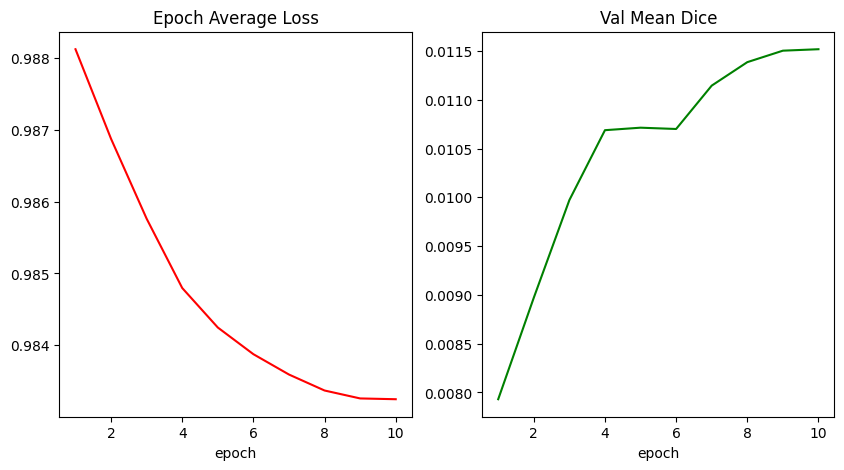

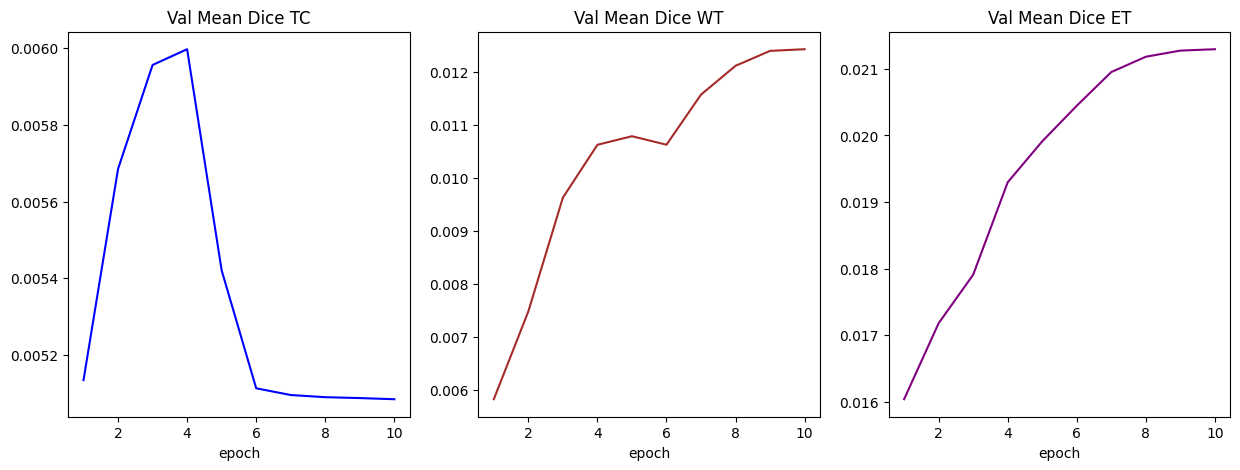

In [17]:
plt.figure("train", (10, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (15, 5))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

### Check best model output with the input image and label

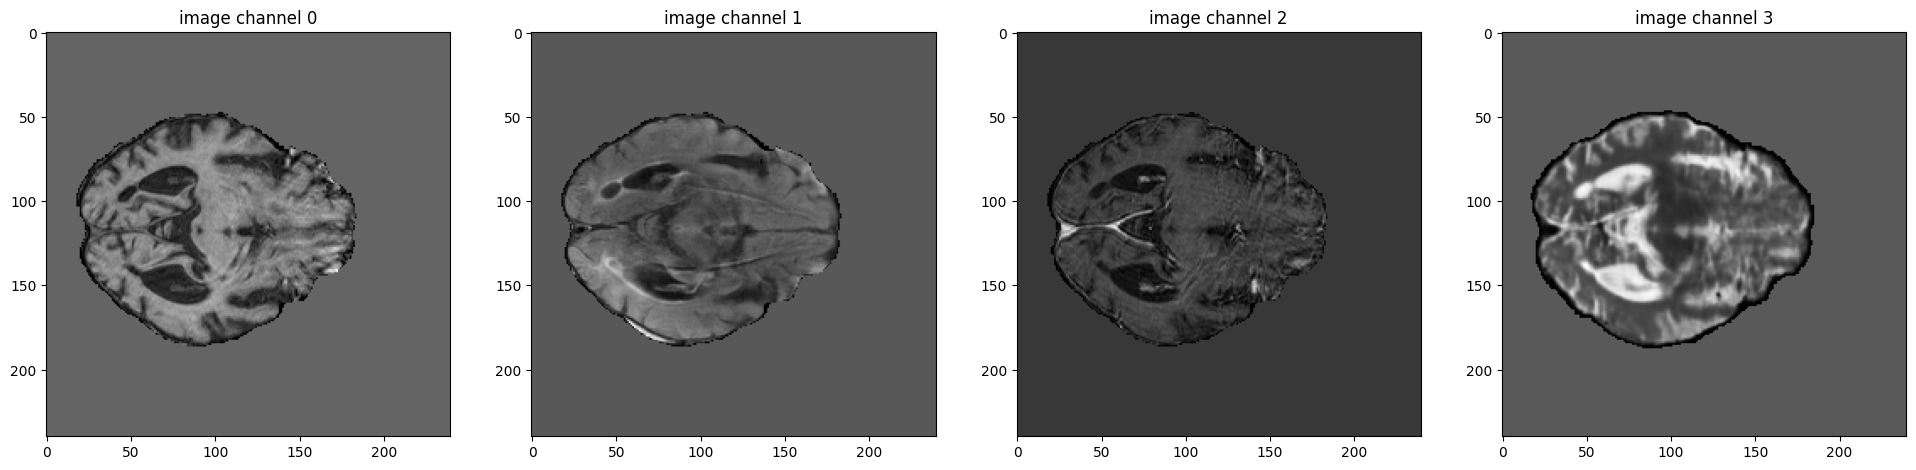

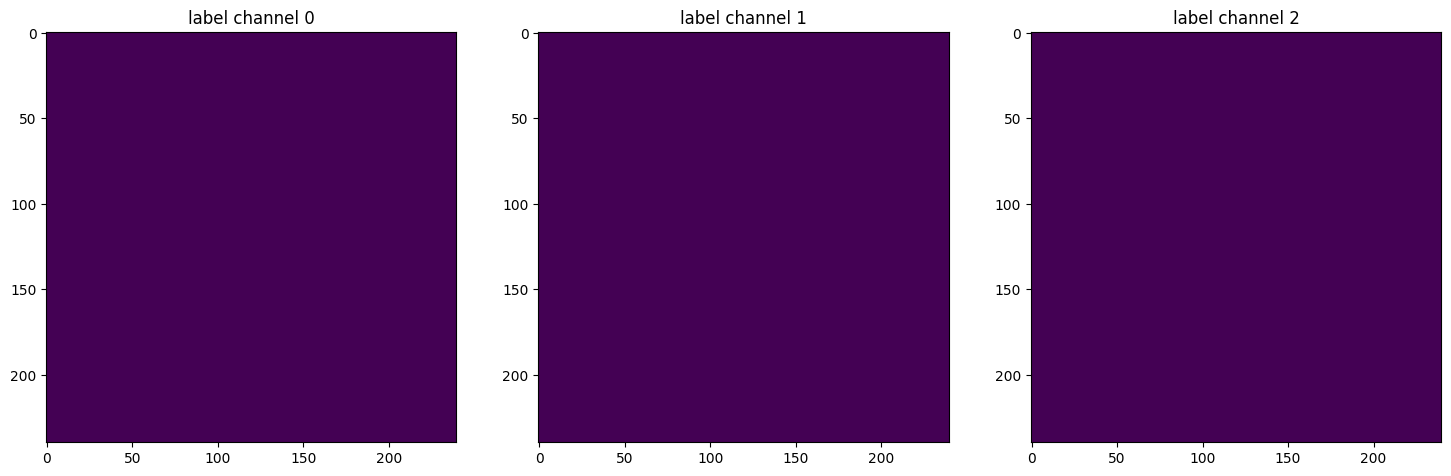

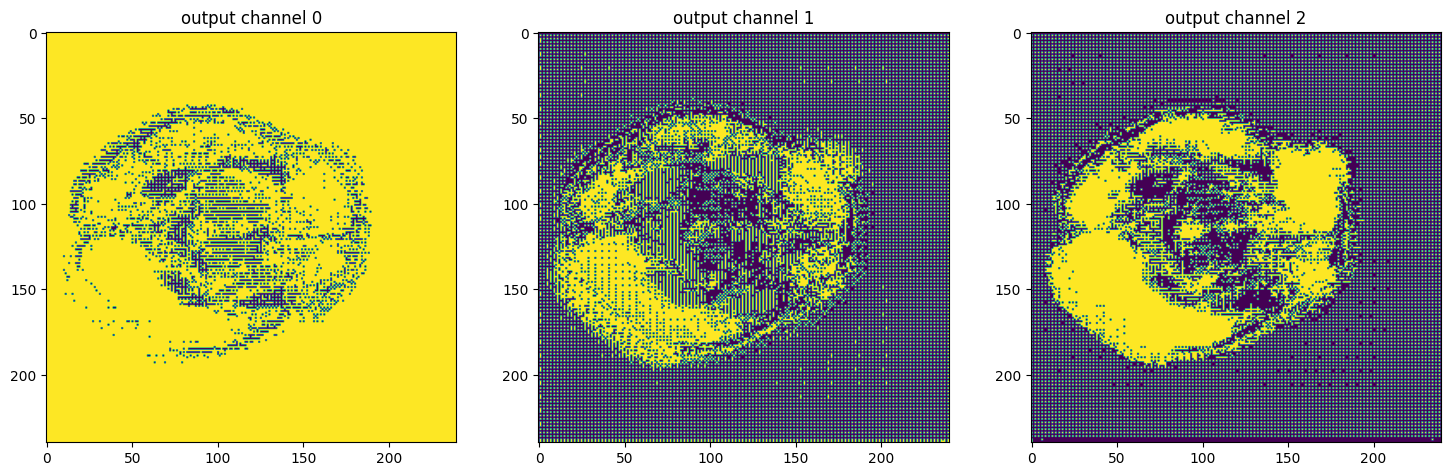

In [18]:
model.load_state_dict(torch.load("outputs/UNet.pth"))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_dataset[0]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_dataset[0]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_dataset[0]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()